<a href="https://colab.research.google.com/github/EvoDmiK/TIL/blob/main/AI_study/paper_implementations/CV/YOLO_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 참고자료**
## **0-1. 도서**  
## **0-2. 논문, 학술지**
- You Only Look Once: Unified, Real-Time Object Detection [[논문 링크]](https://arxiv.org/abs/1506.02640)

## **0-3. 웹 사이트**
- 타키탸키 | Pascal VOC Dataset 탐색 및 실습 [[블로그 링크]](https://velog.io/@tataki26/open-cv)  
- shkim5616 github | YOLO-v1-for-studying | [[깃헙 링크]](https://github.com/shkim5616/YOLO-v1-for-studying)

## **0-4. 데이터셋 출처**
- VOC PASCAL 데이터 셋 | [[데이터 셋 링크]](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)

# **1. 데이터 셋 다운로드 받기**
- 데이터 셋을 저장할 폴더를 생성하고 링크를 통해  Pascal VOC 데이터 셋을 다운로드 받는다.

In [ ]:
!mkdir -p ./dataset/pascal/train
!mkdir -p ./dataset/pascal/test
!mkdir -p ./dataset/zips

!wget -P ./dataset/zips http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!wget -P ./dataset/zips http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget -P ./dataset/zips http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

In [ ]:
!tar -vxf ./dataset/zips/VOCtrainval_11-May-2012.tar -C ./dataset/pascal/train
!tar -vxf ./dataset/zips/VOCtrainval_06-Nov-2007.tar -C ./dataset/pascal/train
!tar -vxf ./dataset/zips/VOCtest_06-Nov-2007.tar -C ./dataset/pascal/test

## **1-1. 데이터 셋을 확인해 보자**
- 압축을 해제한 데이터 셋에는 Annotation 정보가 포함된 xml 파일들과, 이미지들로 구성 되어 있다.

In [ ]:
!pip install imutils
!pip install lxml
!pip install bs4

In [1]:
from imutils.paths import list_files
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2, os
import json

In [2]:
cvt_color  = lambda image: cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
get_coord  = lambda tag, coord, type=int: float(tag.select(coord)[0].text) if type == float else int(tag.select(coord)[0].text)
xml_parser = lambda xml_path: bs(open(xml_path, 'r'), 'lxml')

def show_image(image, cvt = False):
  if cvt: image = cvt_color(image)

  plt.imshow(image)
  plt.axis(False)

  return image

In [3]:
DATASET_PATH       = 'dataset/pascal'
TRAIN_DATASET_PATH = f'{DATASET_PATH}/train/VOCdevkit'

train_xml_paths = sorted(list_files(f'{TRAIN_DATASET_PATH}/VOC2007/Annotations'))

xml_path = train_xml_paths[0]
soup = xml_parser(xml_path)

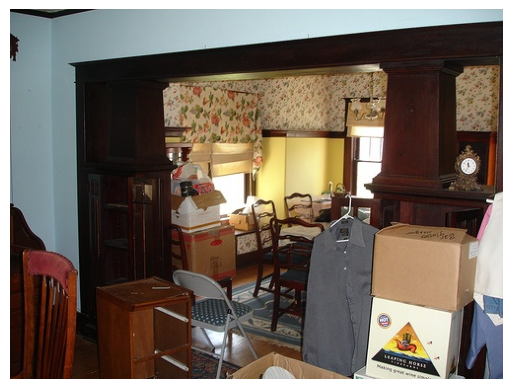

In [4]:
file_name    = soup.select('filename')[0].text
folder_name  = '/'.join(xml_path.split(os.path.sep)[:-2])
image_path   = f'{folder_name}/JPEGImages/{file_name}'

image = cv2.imread(image_path)
image = show_image(image, cvt = True)

- xml 파일이 object > bndbox 안에 좌표가 있어 bs4를 이용해 좌표정보를 가져온다.

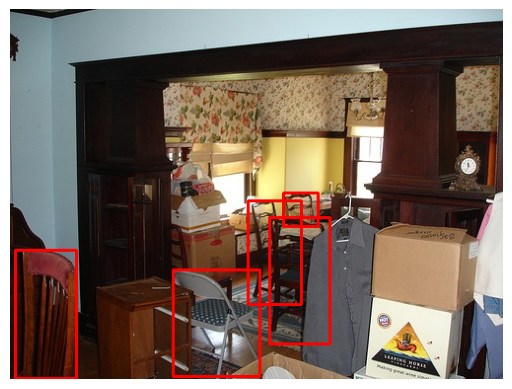

In [5]:
bboxes = soup.select('object > bndbox')
bboxes = [(get_coord(bbox, 'xmin'), get_coord(bbox, 'ymin'), get_coord(bbox, 'xmax'), get_coord(bbox, 'ymax')) for bbox in bboxes]

for bbox in bboxes:
  x_min, y_min, x_max, y_max = bbox
  cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

_ = show_image(image)

## **1-2. 데이터 셋을 전처리 해보자**
- PASCAL VOC 형식의 xml 데이터 셋을 yolo format으로 변경하여 준다.

In [6]:
def normalize(bbox, w, h):
  x_min, y_min, x_max, y_max = bbox

  ## 중심좌표와 너비, 높이는 원래 좌표 값에서 
  ## 이미지의 너비, 높이를 나누어 정규화 해준다.
  center_x = ((x_max + x_min) / 2) / w
  center_y = ((y_max + y_min) / 2) / h

  W = (x_max - x_min) / w
  H = (y_max - y_min) / h

  return (center_x, center_y, W, H)

def pascal2yolo(soup):

  file_name = soup.select('filename')
  width     = int(soup.select('size > width')[0].text) 
  height    = int(soup.select('size > height')[0].text)

  labels = []
  for obj in soup.select('object'):
      bboxes = [(
                get_coord(bbox, 'xmin', float), 
                get_coord(bbox, 'ymin', float), 
                get_coord(bbox, 'xmax', float), 
                get_coord(bbox, 'ymax', float)) 
                for bbox in soup.select('bndbox')]

      # 좌표 정규화 (xml -> yolo 형식으로)
      bboxes = [normalize(bbox, width, height) for bbox in bboxes]
      
      label = [lb.text for lb in obj.select('name')]
      labels.extend(label)

  return bboxes, labels, file_name[0].text

In [7]:
## pascal voc 데이터 셋에 있는 20개의 레이블들
label_set = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
    'dog', 'foot', 'hand', 'head', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
  ]


def save_dataset(xml_paths, dtype = 'train'):
  ## 전처리 결과를 폴더에 저장해주자
  os.makedirs(f'dataset/preproc/{dtype}', exist_ok = True)

  for xml_path in xml_paths:
    soup = xml_parser(xml_path)
    bboxes, labels, fname = pascal2yolo(soup)
    fname, _ = os.path.splitext(fname)

    txt_string = ''
    text_name  = f'dataset/preproc/{dtype}/{fname}.txt'

    for bbox, label in zip(bboxes, labels):
        bbox_str  = ' '.join([str(b) for b in bbox])
        label_idx = label_set.index(label)

        txt_string += f'{label_idx} {bbox_str}\n'
        open(text_name, 'a').write(txt_string)
  

In [8]:
TEST_DATASET_PATH = f'{DATASET_PATH}/test/VOCdevkit'
test_xml_paths = sorted(list_files(f'{TEST_DATASET_PATH}/VOC2007/Annotations'))

save_dataset(train_xml_paths)
save_dataset(test_xml_paths, dtype = 'valid')

In [9]:
open('classes.txt', 'w', encoding = 'utf-8').write(json.dumps(label_set))

219

## **1-3. 데이터 로더를 구성해보자**  

In [10]:
from imutils.paths import list_images, list_files
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

/opt/conda/envs/tensor/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


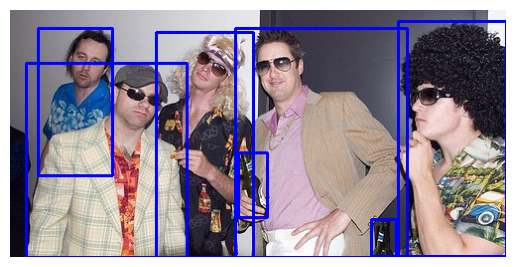

In [11]:
images      = sorted(list_images(f'{TRAIN_DATASET_PATH}/VOC2007/JPEGImages/'))
annotations = sorted(list_files(f'./dataset/preproc'))

image  = cv2.imread(images[99])
annots = open(annotations[99], 'r').readlines()

H, W, _ = image.shape
boxes      = [list(map(float, annot.split())) for annot in annots]

for box in boxes:
  _, x, y, w, h = box

  x1, y1 = int(W * (x - w / 2)), int(H * (y - h / 2))
  x2, y2 = int(x1 + w * W), int(y1 + h * H)

  cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

_ = show_image(image, cvt = True)

In [12]:
class VOCDataset(Dataset):

  def __init__(self, annotations, images, 
               S = 7, B = 2, C = 20, transform = None):

    self.annotations = sorted(list_files(annotations))
    self.image_paths = sorted(list_images(images))
    self.transform   = transform

    self.S, self.B, self.C = S, B, C


  def __len__(self): return len(self.annotations)


  def __getitem__(self, idx):

    annotation = open(self.annotations[idx], 'r').readlines()
    boxes      = [list(map(float, annot.split())) for annot in annotation]
    boxes      = torch.tensor(boxes)
    image      = Image.open(self.image_paths[idx])

    ## transform이 들어가는 경우 이미지 뿐만 아니라 box의 좌표도 변경되어야 해서 입력값에 boxes도 넣음.
    if self.transform: image, boxes = self.transform(image, boxes)

    ## 레이블을 인코딩하여 담을 S x S x (B*5 + C) 사이즈의 텐서 
    label_matrix   = torch.zeros((self.S, self.S, self.C + 5*self.B))
    for box in boxes:
      lb, x, y, w, h = box.tolist()
      
      ## i, j는 셀의 행과 열을 나타냄.
      lb, i, j = int(lb), int(self.S * y), int(self.S * x)

      x_cell, y_cell = j - int(j), i - int(i)

      ## bounding box의 grid cell의 width와 height 구하는 부분
      w_cell, h_cell = ( w * self.S, h * self.S )

      ## object가 없다고 되어 있는 경우
      ## 바운딩 박스의 grid cell에 객체가 하나만 있다고 제한 
      if label_matrix[i, j, 20] == 0:
        box_coords = torch.tensor( [x_cell, y_cell, w_cell, h_cell] )
        
        ## object가 있다고 설정해주기
        label_matrix[i, j, 20]    = 1

        ## 레이블의 인덱스 값을 1로 설정함으로써 원 핫 인코딩해줌
        label_matrix[i, j, lb]    = 1

        ## 벡터의 21 ~ 25번째 값을 박스 좌표값으로 설정해줌.
        label_matrix[i, j, 21:25] = box_coords

    return image, label_matrix

# **2. YOLO v1 모델을 구현해보자**      

In [13]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

## **2-1. 신경망을 구성해보자**  
- 논문에서 (448, 448)의 이미지를 입력받아 최종적으로 7x7x30의 아웃풋이 나오도록 구현되어 있음. 
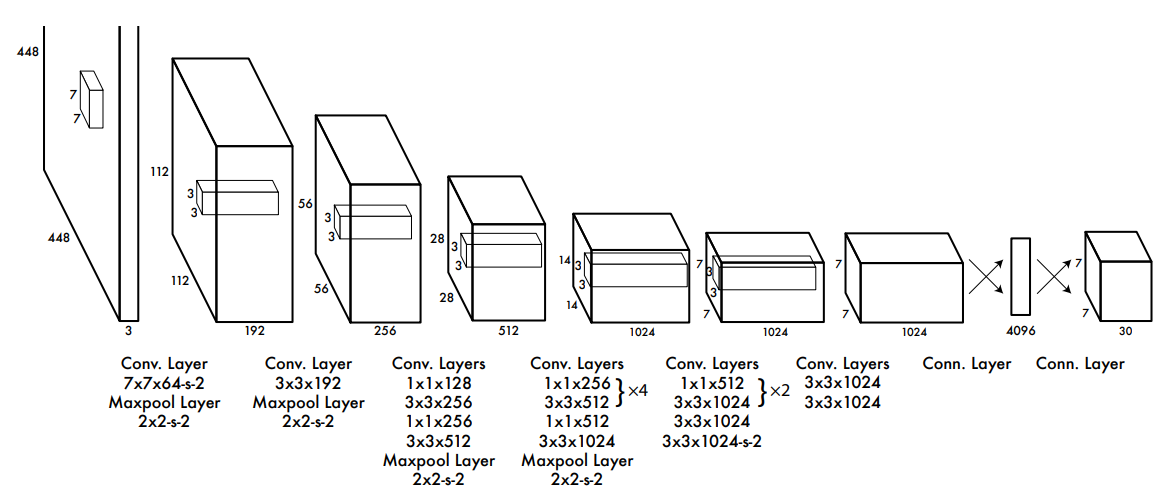

In [14]:
architecture = [
    ## out_channels, kernel_size, stride, padding
    (64, 7, 2, 3),
    'M',
    (192, 3, 1, 1),
    'M',
    (128, 1, 1, 0),
    (256, 3, 1, 1),
    (256, 1, 1, 0),
    (512, 3, 1, 1),
    'M',
    [(256, 1, 1, 0), (512, 3, 1, 1), 4],
    (512, 1, 1, 0),
    (1024, 3, 1, 1),
    'M',
    [(512, 1, 1, 0), (1024, 3, 1, 1), 2],
    (1024, 3, 1, 1),
    (1024, 3, 2, 1),
    (1024, 3, 1, 1),
    (1024, 3, 1, 1),
]

In [15]:
class CNNBlock(nn.Module):

  def __init__(self, in_channels, out_channels, **kwargs):

    super(CNNBlock, self).__init__()
    self.conv      = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
    self.bn        = nn.BatchNorm2d(out_channels)
    self.leakyrelu = nn.LeakyReLU(0.1)

  def forward(self, x):

    x = self.conv(x)
    x = self.bn(x)
    x = self.leakyrelu(x)
    return x 

In [16]:
class Yolov1(nn.Module):

  def __init__(self, in_channels = 3, **kwargs):
    super(Yolov1, self).__init__()
    self.architecture = architecture
    self.in_channels  = in_channels

    self.darknet = self._create_conv_layers(self.architecture)
    self.fcs = self._create_fcs(**kwargs)


  def forward(self, x):
    ## darknet | Convolution layers (feature extractor)
    x = self.darknet(x)
    x = torch.flatten(x, start_dim = 1)

    ## fcs     | Fully connected layers
    return self.fcs(x)

  ## 이 모델은 사전 학습된 모델을 사용하지 않았는데,
  ## 추후 사전학습된 모델로도 구성해 보며 테스트 예정이다.
  def _create_conv_layers(self, archutecture):

    layers = []
    in_channels = self.in_channels

    for archi in architecture:
      if type(archi) == tuple:
      
        layers += [
                    CNNBlock(in_channels,  archi[0],
                             kernel_size = archi[1],
                             stride      = archi[2],
                             padding     = archi[3])
                  ]

        in_channels = archi[0]

      elif type(archi) == str:
        layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]

      elif type(archi) == list:
        conv1, conv2, num_repeats = archi

        for _ in range(num_repeats):

          layers += [
                      CNNBlock(
                          in_channels,  conv1[0],
                          kernel_size = conv1[1],
                          stride      = conv1[2],
                          padding     = conv1[3])
                    ]

          layers += [
                      CNNBlock(
                          conv1[0],     conv2[0],
                          kernel_size = conv2[1],
                          stride      = conv2[2],
                          padding     = conv2[3])
                    ]

          in_channels = conv2[0]

    return nn.Sequential(*layers)


  def _create_fcs(self, split_size, num_boxes, num_classes):

    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(
              nn.Flatten(),
              nn.Linear(1024*S*S, 4096),
              nn.Dropout(0.5),
              nn.LeakyReLU(0.1),
              nn.Linear(4096, S*S*(C+B*5))
            )

In [17]:
## 제대로 구현되었는지 테스트 해보자
model = Yolov1(split_size = 7, num_boxes = 2, num_classes = 20)

x = torch.randn((2, 3, 448, 448))
print(model(x).shape)

torch.Size([2, 1470])


# **3. 필요한 함수를 정의해보자**


In [18]:
from collections import Counter, deque

## **3-1 성능지표 계산 클래스를 정의해 보자**
- 클래스 안에는 IoU, mAP 함수들이 정의되어 있다.

In [19]:
## 성능 지표를 계산하는 함수들을 모아둔 클래스
## IoU, mAP가 저장되어 있음.

class Metrices:

  def IoU(box_pred:torch.tensor, box_gt:torch.tensor, box_format = "center"):

    if box_format == 'center':
      ## 중심점으로 부터 박스의 좌표를 구할때
      ## 좌표 값이 [center_x, center_y, w, h]로 들어가고 나옴
      x1_pred = box_pred[..., 0:1] - (box_pred[..., 2:3] / 2)
      y1_pred = box_pred[..., 1:2] - (box_pred[..., 3:4] / 2)
      x2_pred = box_pred[..., 0:1] + (box_pred[..., 2:3] / 2)
      y2_pred = box_pred[..., 1:2] + (box_pred[..., 3:4] / 2)

      x1_gt = box_gt[..., 0:1] - (box_gt[..., 2:3] / 2)
      y1_gt = box_gt[..., 1:2] - (box_gt[..., 3:4] / 2)
      x2_gt = box_gt[..., 0:1] + (box_gt[..., 2:3] / 2)
      y2_gt = box_gt[..., 1:2] + (box_gt[..., 3:4] / 2)

    elif box_format == 'corner':
      ## 좌표 값이 [x1, y1,x2, y2]로 주어지는 경우
      x1_pred = box_pred[..., 0:1]
      y1_pred = box_pred[..., 1:2]
      x2_pred = box_pred[..., 2:3]
      y2_pred = box_pred[..., 3:4]

      x1_gt = box_gt[..., 0:1]
      y1_gt = box_gt[..., 1:2]
      x2_gt = box_gt[..., 2:3]
      y2_gt = box_gt[..., 3:4]

    
    x1_inter = torch.max(x1_pred, x1_gt)
    x2_inter = torch.min(x2_pred, x2_gt)

    y1_inter = torch.max(y1_pred, y1_gt)
    y2_inter = torch.min(y2_pred, y2_gt)

    area_inter = (x2_inter - x1_inter).clamp(0) * (y2_inter - y1_inter).clamp(0)
    area_pred  = abs((x2_pred - x1_pred)*(y2_pred - y1_pred))
    area_gt    = abs((x2_gt - x1_gt) * (y2_gt - y1_gt))

    ## 분모가 0이 되지 않도록 하는 값 추가
    eps = 1e-6
    return area_inter / (area_pred + area_gt - area_inter + eps)


  def mAP(boxes_pred, boxes_gt, iou_threshold = 0.5, box_format = 'center', n_classes = 20):

    ## average_precisions | AP를 구해서 저장해주는 리스트
    ## eps                | recall과 precision을 구할때 나누는 값이 0이 되지 않도록 하는 값
    average_precisions = []
    eps = 1e-6

    for class_idx in range(n_classes):

      ## 현재 레이블에 맞게 검출한 박스들만 걸러내는 작업
      detections    = [det for det in boxes_pred if det[1] == class_idx]
      ground_truths = [gt for gt in boxes_gt if gt[1] == class_idx]

      ## 이미지 별로 ground truth의 bbox 갯수가 몇 개인지 집계
      amount_bboxes = Counter([gt[0] for gt in ground_truths])
      for k, v in amount_bboxes.items(): amount_bboxes[k] = torch.zeros(v)

      ## 검출한 녀석들 중에서 confidence 순으로 내림차 순 정렬
      detections = sorted(detections, key = lambda x: x[2], reverse = True)
      
      ## 제대로 잡은 녀석과 잡지 말아야할 녀석을 잡은 녀석을 표시하는 텐서
      TP = torch.zeros((len(detections)))
      FP = torch.zeros((len(detections)))
      total_true_bboxes = len(ground_truths)

      ## 해당 레이블로 검출한 녀석이 없는 경우에는 그냥 넘김
      if total_true_bboxes == 0: continue

      for det_idx, detection in enumerate(detections):

        ## ground truth 이미지 중에서 검출한 이미지와 동일한 이미지만 남김
        gt_images = [
                      bbox for bbox in ground_truths if bbox[0] == detection[0]
                    ]

        num_gts, best_iou = len(gt_images), 0
        for idx, gt in enumerate(gt_images):
          iou = Metrices.IoU(
                  torch.tensor(detection[3:]),
                  torch.tensor(gt[3:]),
                  box_format = box_format
                )
          if iou > best_iou:
            best_iou    = idx
            best_gt_idx = idx

        if best_iou > iou_threshold:
          if amount_bboxes[detection[0]][best_gt_idx] == 0:
            TP[det_idx] = 1
            amount_bboxes[detection[0]][best_gt_idx] = 1

          else:
            FP[det_idx] = 1

        else:
          FP[det_idx] = 1
      
      TP_sum = torch.cumsum(TP, dim = 0)
      FP_sum = torch.cumsum(FP, dim = 0)

      recalls    = TP_sum / (total_true_bboxes + eps)
      precisions = torch.divide(TP_sum, (TP_sum + FP_sum + eps))
      precisions = torch.cat((torch.tensor([1]), precisions))
      recalls    = torch.cat((torch.tensor([0]), recalls))

      ## torch.trapz() 사다리꼴 적분. 즉, AP를 구하는 부분
      average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [20]:
## 제대로 구현되었는지 테스트 해보자

box_pred  = torch.tensor([20, 30, 120, 130])
box_pred2 = torch.tensor([15, 25, 115, 125])
box_gt    = torch.tensor([25, 35, 125, 135])

print(f'IoU       | {Metrices.IoU(box_gt, box_pred)}')
print(f'IoU2      | {Metrices.IoU(box_gt, box_pred2)}')

IoU       | tensor([0.8564])
IoU2      | tensor([0.7313])


### **3-2 유틸리티 클래스를 정의해 보자**
- 클래스 안에는 체크포인트 관련 함수들과 후처리 관련 함수들이 정의되어 있다.

In [21]:
## 데이터 후처리 관련된 함수 및 모델 저장 관련 함수들이 들어있는 클래스
class Utils:

  def convert_cells(predictions, S = 7):
    
    predictions = predictions.to('cpu')
    batch_size  = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, 30)

    bboxes1 = predictions[... , 21:25]
    bboxes2 = predictions[... , 26:30]

    scores  = torch.cat(
                        (predictions[... , 20].unsqueeze(0), predictions[... , 25].unsqueeze(0)), dim = 0
                      )

    best_box     = scores.argmax(0).unsqueeze(-1)
    best_boxes   = bboxes1 * (1 - best_box) + bboxes2 * best_box
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)

    x   = 1 / S * (best_boxes[... , :1] + cell_indices)
    y   = 1 / S * (best_boxes[... , 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_h = 1 / S * best_boxes[... , 2:4] 

    print(x.shape, y.shape, w_h.shape)
    converted_bboxes = torch.cat((x, y, w_h), dim = 1)
    predicted_class  = predictions[... , :20].argmax(-1).unsqueeze(-1)
    best_confidence  = torch.max(predictions[... , :20], predictions[... , 25]).unsqueeze(-1)

    return torch.cat((predicted_class, best_confidence, converted_bboxes), dim = -1)


  def cells2boxes(out, S = 7):
    
    converted_pred          = Utils.convert_cells(out).reshape(out.shape[0], S*S, -1)
    converted_pred[... , 0] = converted_pred[... , 0].long()
    
    
    all_bboxes = []
    for idx in range(out.shape[0]):

      bboxes = []
      for bbox_idx in range(S*S): bboxes.append([x.item() for x in converted_pred[idx, bbox_idx, : ]])
      all_bboxes.append(bboxes)

    return all_bboxes


  def NMS(bboxes, iou_threshold, conf_threshold, box_format = 'corner'):

      ## bbox는 [검출 레이블, confidence, x1, y1, x2, y2]로 구성된 리스트
      assert type(bboxes) == list

      ## confidence threshold 보다 작은 녀석들 제거
      bboxes = [bbox for bbox in bboxes if bbox[1] > conf_threshold]

      ## confidence가 높은 녀석 순서로 내림차순 정렬
      bboxes = sorted(bboxes, key = lambda x: x[1], reverse = True)

      ## NMS 이후에 남아있는 박스들
      nms_bboxes = []
      bboxes = deque(bboxes)

      while bboxes:
        base_box = bboxes.popleft()

        bboxes = deque([
                          bbox for bbox in bboxes
                          if (bbox[0] != base_box[0])
                          or (Metrices.IoU(
                                torch.tensor(base_box[2:]),
                                torch.tensor(bbox[2:]),
                                box_format = box_format
                              )) < iou_threshold
                      ])
        
        nms_bboxes.append(base_box)

      return nms_bboxes


  def get_bboxes(loader, model, iou_threshold, conf_threshold, pred_format = 'cells',
                 box_format = 'midpoint', device = 'cuda'):
    
    all_pred_boxes, all_gt_boxes = [], []
    model.eval()

    train_idx = 0
    for batch_idx, (images, labels) in enumerate(loader):

      images, labels = images.to(device), labels.to(device)
      with torch.no_grad(): predictions = model(images)

      batch_size  = images.shape[0]
      gt_bboxes   = Utils.cells2boxes(labels)
      pred_bboxes = Utils.cells2boxes(predictions)

      for idx in range(batch_size):
        nms_boxes = Utils.NMS(bboxes[idx], iou_threshold = iou_threshold, 
                                 conf_threshold = conf_threshold, box_format = box_format)
        
        for nms_box in nms_boxes: all_pred_boxes.append([train_idx] + nms_box)
        for box in gt_bboxes[idx]:
            if box[1] > conf_threshold: all_gt_boxes.append([train_idx] + box)

        train_idx += 1

      model.train()
      return all_pred_boxes, all_gt_boxes


  def save_checkpoint(state, filename = 'my_checkpoint.pth'):
    print('\n[save checkpoint]\n')
    torch.save(state, filename)

  
  def load_checkpoint(checkpoint, model, optimizer):
    print('\n [load checkpoint] \n')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])


  def plot_image(image, boxes):

    image    = np.array(image)
    h, w, _  = image.shape
    fig, ax  = plt.subplots(1)
    ax.imshow(image)

    for box in boxes:
      box = box[2:]
      assert len(box) == 4, 'Got more values than (x, y, w, h) in a box'

      x_1, y_1 = (box[0] - box[2] / 2) * w, (box[1] - box[3] / 2) * h
      x_2, y_2 = x_1 + box[2] * w, y_1 + box[3] * h

      cv2.rectangle(image, (int(y_1), int(x_1)), (int(y_2), int(x_2)), (255, 0, 0), 1)

    plt.imshow(image)

NMS Boxes | [['pigeon', 0.9, 50, 135, 150, 235], ['dove', 0.8, 25, 35, 125, 135]] 




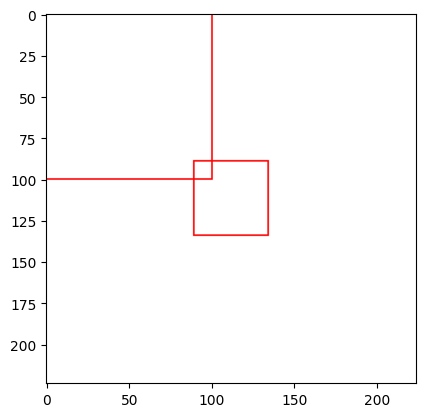

In [22]:
## 이녀석도 제대로 구현되었는지 테스트 해보자
nms_boxes = Utils.NMS([
    ## ground truth와 거의 근접하게 검출한 녀석
    ['dove', 0.8, 25, 35, 125, 135], 

    ## 첫 번째 녀석과 IoU가 낮게 측정되는 녀석
    ['pigeon', 0.9, 50, 135, 150, 235],

    ## confidence가 낮은 녀석
    ['pigeon', 0.3, 20, 30, 120, 130], 

    ## 첫 번쩨 녀석과 레이블이 겹치는 녀석
    ['dove', 0.7, 15, 25, 115, 125]], 0.3, 0.5)

print(f'NMS Boxes | {nms_boxes} \n\n')

image = np.ones((224, 224, 3), dtype = np.uint8) * 255
boxes = [[0, 0, 0.5, 0.5, 0.2, 0.2], [0, 0, 0.2, 0.2, 0.5, 0.5]]

Utils.plot_image(image, boxes)

# **4. 로스함수를 정의해보자**
## **4-1. YOLO v1에서 사용된 함수를 정의해 보자**


In [23]:
class YoloLoss(nn.Module):

  def __init__(self, S = 7, B = 2, C = 20):
    
    super(YoloLoss, self).__init__()

    self.S, self.B, self.C = S, B, C
    self.mse = nn.MSELoss(reduction = 'sum')

    self.lambda_noobj = 0.5
    self.lambda_coord = 5

  
  def forward(self, predictions, target):

    ## 논문에서 나와있는대로 출력값은 (batch_size, 7*7, 30)의 사이즈를 가진다. 
    predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
    
    ## prediction과 target의 21 ~ 24번째 원소는 각각 (x중심 좌표, y중심 좌표, w, h)이다.
    iou_b1 = Metrices.IoU(predictions[... , 21: 25], target[... , 21: 25])
    iou_b2 = Metrices.IoU(predictions[... , 26: 30], target[... , 26: 30])
    ious   = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim = 0)

    ## best box를 이용해서 2개의 bbox 중 gt와 iou가 높은 것을 선택한다.
    iou_maxes, best_box = torch.max(ious, dim = 0)
    
    ## Iobj를 구하는 부분 -> 객체가 존재한다면 1, 존재하지 않으면 0을 가진다.
    exists_box = target[... , 20].unsqueeze(3)

    # For BOX COORDINATES
    box_predictions = exists_box * (( 
                                    best_box * predictions[..., 26:30] + 
                                    (1-best_box) * predictions[..., 21:25]
                                  ))

    box_targets = exists_box * target[..., 21:25]

    box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
        torch.abs(box_predictions[..., 2:4] + 1e-6)  # 예측한 h,w 루트 연산 in paper
    )

    # (N, S, S, 25)
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])  #gt의 h,w 루트 연산 in paper

    # flatten 전: (N, S, S, 4) -> flatten 후: (N*S*S, 4)
    box_loss = self.mse(
        torch.flatten(box_predictions, end_dim=-2),
        torch.flatten(box_targets, end_dim=-2)
    )

    # FOR OBJECT LOSS
    pred_box = (
        best_box * predictions[..., 25:26] + (1-best_box) * predictions[..., 20:21]
    )

    # (N*S*S)
    object_loss = self.mse(
        torch.flatten(exists_box * pred_box),
        torch.flatten(exists_box * target[..., 20:21] * iou_maxes)  # confidence score를 이용해 loss 계산하기 위해 iou_maxes를 곱해준다.
    )

    # FOR NO OBJECT LOSS
    #  flatten 전: (N, S, S, 1) -> flatten 후: (N, S*S)
    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
    )

    no_object_loss += self.mse(
        torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
    )

    # FOR CLASS LOSS
    # flatten 전: (N,S,S,20) -> flatten 후: (N*S*S, 20)
    class_loss = self.mse(
        torch.flatten(exists_box * predictions[..., :20], end_dim=-2),
        torch.flatten(exists_box * target[..., :20], end_dim=-2)
    )
    

    loss = (
        self.lambda_coord * box_loss  # First two rows of loss in paper
        + object_loss
        + self.lambda_noobj * no_object_loss
        + class_loss
    )

    return loss


# **5. 학습에 필요한 함수를 정의해보자**


In [24]:
import torchvision.transforms.functional as FT
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

In [25]:
seed = 999
torch.manual_seed(seed)

In [26]:
LOAD_MODEL_PATH = 'overfit.pth.tar'
WEIGHT_DECAY    = 0
NUM_WORKERS     = 1
PIN_MEMORY      = True
LOAD_MODEL      = False
LOAD_MODEL_FILE = 'pretrained.pt'

EPOCHS = 1000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR     = 1e-5
BS     = 16 

In [27]:
class Compose(object):

  def __init__(self, transforms): self.transforms = transforms

  def __call__(self, image, bboxes):
    for transform in self.transforms:
      image, bboxes = transform(image), bboxes

    return image, bboxes

In [32]:
def train_fn(epoch, train_loader, model, optimizer, loss_fn):

  loop      = tqdm(train_loader, leave = True)
  mean_loss = []

  for image, label in loop:

    image, label = image.to(DEVICE), label.to(DEVICE) 
    out  = model(image)

    # print(out.size(), label.size())
    loss = loss_fn(out, label)

    mean_loss.append(loss.item())
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

  if epoch % 10 == 0: print(f'[{epoch} TRAIN] mean loss was {sum(mean_loss) / len(mean_loss)}') 


def valid_fn(epoch, valid_loader, model, loss_fn):

  loop      = tqdm(valid_loader, leave = True)
  mean_loss = []

  with torch.no_grad():
    for image, label in loop:
      image, label = image.to(DEVICE), label.to(DEVICE) 
      out  = model(image)
      loss = loss_fn(out, label)

      mean_loss.append(loss.item())

  if epoch %10 == 0: print(f'[{epoch} VALID] mean loss was {sum(mean_loss) / len(mean_loss)}') 


In [33]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(), ])

In [34]:
def main(model, transform):
  
  model     = model.to(DEVICE)
  optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

  loss_fn = YoloLoss()
  if LOAD_MODEL: Utils.load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

  train_dataset = VOCDataset(
                    annotations = 'dataset/preproc/train',
                    images      = f'{TRAIN_DATASET_PATH}/VOC2007/JPEGImages/',
                    transform   = transform
                  )

  valid_dataset = VOCDataset(
                    annotations = 'dataset/preproc/valid',
                    images      = f'{TEST_DATASET_PATH}/VOC2007/JPEGImages/',
                    transform   = transform
                  )
  
  train_loader  = DataLoader(
                    train_dataset, batch_size = BS, num_workers = NUM_WORKERS,
                    pin_memory = PIN_MEMORY, shuffle = True, drop_last = True
                  )
  
  valid_loader  = DataLoader(
                  valid_dataset, batch_size = BS, num_workers = NUM_WORKERS,
                  pin_memory = PIN_MEMORY, shuffle = True, drop_last = True
                )
  
  for epoch in range(EPOCHS):
    # pred_boxes, target_boxes = Utils.get_bboxes(
    #                                 train_loader, model, iou_threshold = 0.5, conf_threshold = 0.4
    #                             )
    
    # train_mAP = Metrices.mAP(
    #               pred_boxes, target_boxes, iou_threshold = 0.5, box_format = 'midpoint'
    #             )
    
    # print(f'[TRAIN] {epoch + 1} / {EPOCHS} mAP : {train_mAP}')
    train_fn(epoch, train_loader, model, optimizer, loss_fn)
    valid_fn(epoch, valid_loader, model, loss_fn)

In [ ]:
main(model, transform)

100%|██████████| 313/313 [08:53<00:00,  1.70s/it]


[0 TRAIN] mean loss was 353.83398642250523


100%|██████████| 309/309 [01:54<00:00,  2.69it/s]


[0 VALID] mean loss was 266.5862378858054


100%|██████████| 313/313 [08:39<00:00,  1.66s/it]


[10 TRAIN] mean loss was 154.83073946919305


100%|██████████| 309/309 [01:50<00:00,  2.80it/s]


[10 VALID] mean loss was 180.9796416396848


100%|██████████| 313/313 [09:08<00:00,  1.75s/it]


[20 TRAIN] mean loss was 106.68830672925273


100%|██████████| 309/309 [03:15<00:00,  1.58it/s]


[20 VALID] mean loss was 172.43269367897008


100%|██████████| 313/313 [09:02<00:00,  1.73s/it]


[30 TRAIN] mean loss was 78.67625764840707


100%|██████████| 309/309 [02:06<00:00,  2.45it/s]


[30 VALID] mean loss was 167.5094599800974


100%|██████████| 313/313 [09:26<00:00,  1.81s/it]


[40 TRAIN] mean loss was 66.16998193515376


100%|██████████| 309/309 [03:20<00:00,  1.54it/s]


[40 VALID] mean loss was 164.5307117202907


 82%|████████▏ | 257/313 [07:40<01:34,  1.69s/it]